In [1]:
import os
print(os.getcwd())
# read files on drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ece657A3/classmodels')

/content
Mounted at /content/drive


In [ ]:
# libraries
import numpy as np
# print(np.__version__)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Softmax,Dropout,Input, Add

from tensorflow.keras import optimizers
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN
from sklearn.manifold import TSNE

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import random
from tensorflow.keras.utils import plot_model


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


from googlenet import *
# from googlenet import googlenet

2.18.0


In [ ]:
mnst_trf = pd.read_csv("/content/drive/MyDrive/ece657A3/x_train.csv", dtype=float)
mnst_tef = pd.read_csv("/content/drive/MyDrive/ece657A3/x_test.csv", dtype=float)
mnst_trl = pd.read_csv("/content/drive/MyDrive/ece657A3/y_train.csv", dtype=float)
mnst_tel = pd.read_csv("/content/drive/MyDrive/ece657A3/y_test.csv", dtype=float)

mn_train = mnst_trf.copy()
mn_test = mnst_tef.copy()

mn_train['label'] = mnst_trl.values
mn_test['label'] = mnst_tel.values

mn_train['dataset'] = 'train'
mn_test['dataset'] = 'test'

mnist_all = pd.concat([mn_train, mn_test], axis=0, ignore_index=True)

print(mnist_all.shape)
display(mnist_all)


# train-validation-test data

X_train_val = mnist_all[mnist_all['dataset'] == 'train'].iloc[:, :-2].values
X_test = mnist_all[mnist_all['dataset'] == 'test'].iloc[:, :-2].values

y_train_val = mnist_all[mnist_all['dataset'] == 'train']['label'].values
y_test = mnist_all[mnist_all['dataset'] == 'test']['label'].values


X_train_val = X_train_val / 255.0
X_test = X_test / 255.0

# (samples, height, width, channels)
X_train_val = X_train_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)


# one-hot for loss='categorical_crossentropy'
y_train_val_cat = to_categorical(y_train_val, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)


(70000, 786)


,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,label,dataset
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,train
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,train
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,train
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,test
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,test
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,test
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,test


In [ ]:
# # train-validation dataset split
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    X_train_val, y_train_val_cat, test_size=0.2, random_state=42
)

# 1. base model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,223,909 (12.30 MB)

 Trainable params: 3,223,909 (12.30 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8045 - loss: 0.5299 - val_accuracy: 0.9466 - val_loss: 0.1747
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9457 - loss: 0.1714 - val_accuracy: 0.9526 - val_loss: 0.1503
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9554 - loss: 0.1413 - val_accuracy: 0.9575 - val_loss: 0.1345
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9603 - loss: 0.1246 - val_accuracy: 0.9638 - val_loss: 0.1162
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9645 - loss: 0.1142 - val_accuracy: 0.9671 - val_loss: 0.1076
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9672 - loss: 0.1030 - val_accuracy: 0.9667 - val_loss: 0.1064
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9680 - loss: 0.1007 - val_accuracy: 0.9677 - val_loss: 0.0977
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9699 - loss: 0.0960 - val_accuracy: 0.

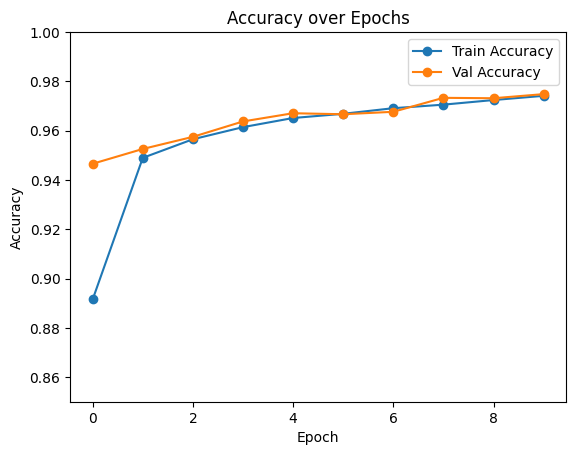

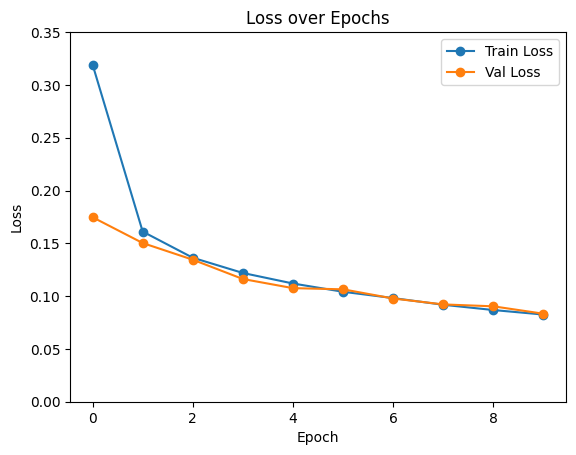

In [ ]:
# training time is so long that we have to interrupt the trainning process for the 2nd time of running the code after finishing report.
# but the result can be guaranteed to be same/similar as in the report
# of course, maybe not same as report, because the running result will not be STRICTLY same each time training deep learning model
# you can run the code to check result.

# construct model
model = Sequential()

# input layer + 1st conv layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
                 activation='relu', input_shape=(28,28,1)))

# 1st pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd conv layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# Flatten
model.add(Flatten())

# fully connected layer：output 512 netron
model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))

# output layer：5 categories + softmax
model.add(Dense(5, activation='softmax'))

# compile
model.compile(
              optimizer=optimizers.SGD(),
              # optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

display(model.summary())



checkpoint_path = '/content/drive/MyDrive/ece657A3/best_base_model.keras'  #
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    # X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)



# 2. adam + early stopping

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,223,909 (12.30 MB)

 Trainable params: 3,223,909 (12.30 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9331 - loss: 0.1891 - val_accuracy: 0.9792 - val_loss: 0.0654
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9826 - loss: 0.0526 - val_accuracy: 0.9821 - val_loss: 0.0523
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9875 - loss: 0.0346 - val_accuracy: 0.9833 - val_loss: 0.0507
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9910 - loss: 0.0255 - val_accuracy: 0.9846 - val_loss: 0.0501
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9939 - loss: 0.0179 - val_accuracy: 0.9862 - val_loss: 0.0448
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9946 - loss: 0.0138 - val_accuracy: 0.9829 - val_loss: 0.0606
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9959 - loss: 0.0109 - val_accuracy: 0.9860 - val_loss: 0.0547
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9967 - loss: 0.0087 - val_accuracy: 0.

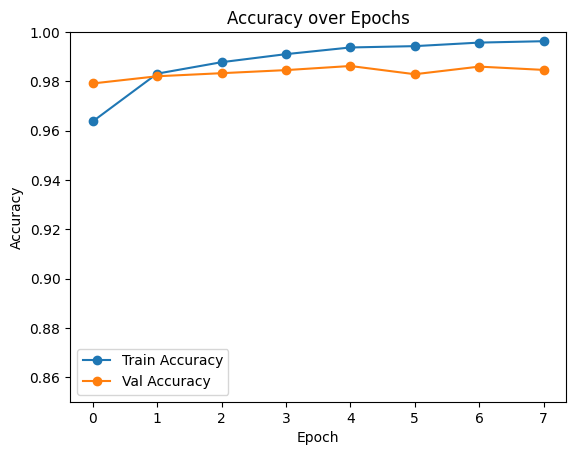

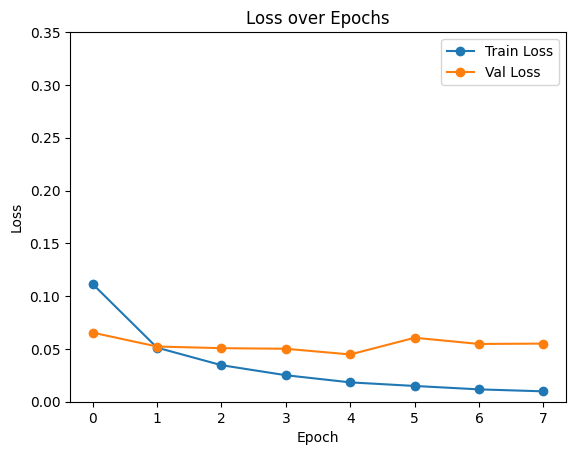

In [ ]:
# training time is so long that we have to interrupt the trainning process for the 2nd time of running the code after finishing report.
# but the result can be guaranteed to be same/similar as in the report
# of course, maybe not same as report, because the running result will not be STRICTLY same each time training deep learning model
# you can run the code to check result.

# construct model
model = Sequential()

# input layer + 1st conv layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
                 activation='relu', input_shape=(28,28,1)))

# 1st pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd conv layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# Flatten
model.add(Flatten())

# fully connected layer：output 512 netron
model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))

# output layer：5 categories + softmax
model.add(Dense(5, activation='softmax'))

# compile
model.compile(
              # optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

display(model.summary())



early_stop = EarlyStopping(
    monitor='val_loss',         # 监控验证集上的loss
    patience=3,                 # 如果3个epoch内val_loss没有下降，则停止训练
    restore_best_weights=True  # 自动恢复到val_loss最小的模型权重
)
checkpoint_path = '/content/drive/MyDrive/ece657A3/best_base_model.keras'  #
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    # X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)



# 3. more fully connecte network

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,353,957 (12.79 MB)

 Trainable params: 3,353,957 (12.79 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9281 - loss: 0.1988 - val_accuracy: 0.9810 - val_loss: 0.0653
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9829 - loss: 0.0498 - val_accuracy: 0.9850 - val_loss: 0.0493
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9887 - loss: 0.0320 - val_accuracy: 0.9852 - val_loss: 0.0462
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9922 - loss: 0.0225 - val_accuracy: 0.9837 - val_loss: 0.0628
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9938 - loss: 0.0176 - val_accuracy: 0.9848 - val_loss: 0.0627
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9952 - loss: 0.0132 - val_accuracy: 0.9852 - val_loss: 0.0564

⏱ Training time: 29.60 seconds

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9853 - loss: 0.0494
Test Accuracy: 0.9860


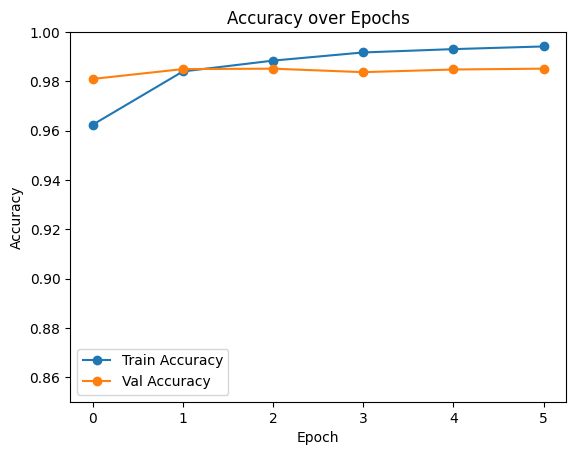

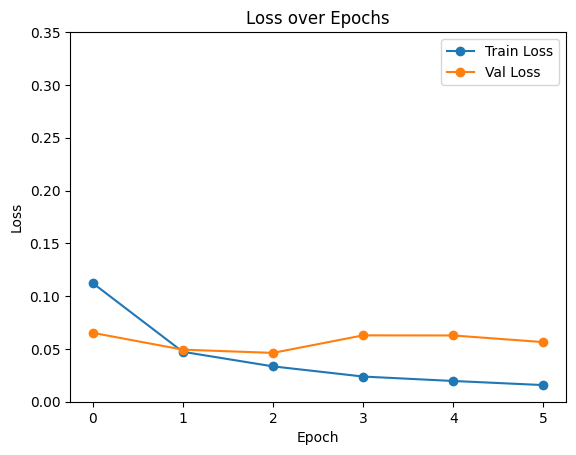

In [ ]:
# training time is so long that we have to interrupt the trainning process for the 2nd time of running the code after finishing report.
# but the result can be guaranteed to be same/similar as in the report
# of course, maybe not same as report, because the running result will not be STRICTLY same each time training deep learning model
# you can run the code to check result.

# construct model
model = Sequential()

# input layer + 1st conv layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
                 activation='relu', input_shape=(28,28,1)))

# 1st pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd conv layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# Flatten
model.add(Flatten())

# fully connected layer：output 512 netron
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

# output layer：5 categories + softmax
model.add(Dense(5, activation='softmax'))

# compile
model.compile(
              # optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

display(model.summary())



early_stop = EarlyStopping(
    monitor='val_loss',         # 监控验证集上的loss
    patience=3,                 # 如果3个epoch内val_loss没有下降，则停止训练
    restore_best_weights=True  # 自动恢复到val_loss最小的模型权重
)
checkpoint_path = '/content/drive/MyDrive/ece657A3/best_base_model.keras'  #
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    # X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)



# 4. more convolution layers

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 963,205 (3.67 MB)

 Trainable params: 963,205 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8986 - loss: 0.2736 - val_accuracy: 0.9817 - val_loss: 0.0625
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9823 - loss: 0.0571 - val_accuracy: 0.9811 - val_loss: 0.0576
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9882 - loss: 0.0391 - val_accuracy: 0.9843 - val_loss: 0.0488
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9896 - loss: 0.0311 - val_accuracy: 0.9846 - val_loss: 0.0509
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9906 - loss: 0.0274 - val_accuracy: 0.9860 - val_loss: 0.0437
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9933 - loss: 0.0192 - val_accuracy: 0.9858 - val_loss: 0.0492
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9924 - loss: 0.0205 - val_accuracy: 0.9842 - val_loss: 0.0496
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9938 - loss: 0.0184 - val_accuracy: 0

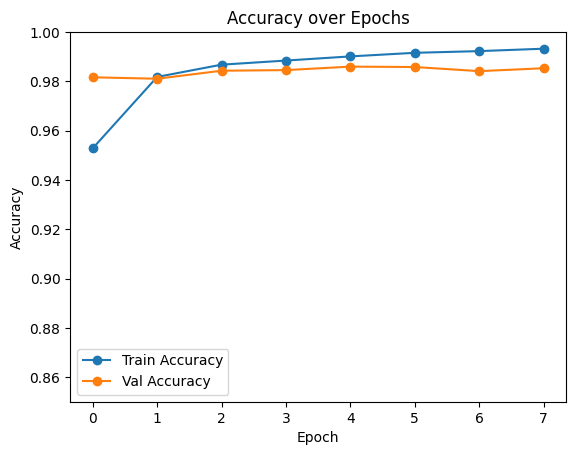

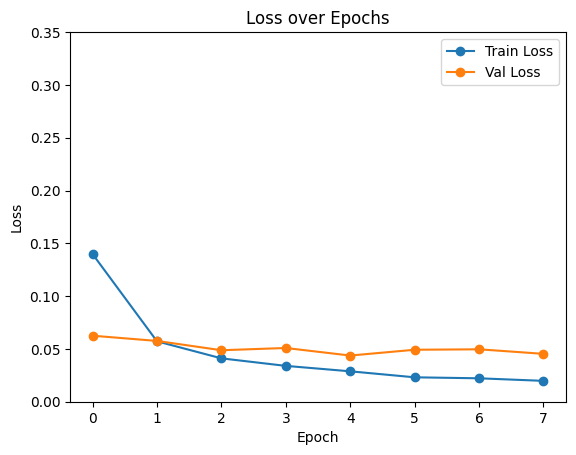

In [ ]:
# training time is so long that we have to interrupt the trainning process for the 2nd time of running the code after finishing report.
# but the result can be guaranteed to be same/similar as in the report
# of course, maybe not same as report, because the running result will not be STRICTLY same each time training deep learning model
# you can run the code to check result.


## add conv
model = Sequential([
    # conv 1 + pooling
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    # Dropout(0.25),

    # conv 2 + pooling
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    # Dropout(0.25),

    # conv3 （pooling not neccessary）
    Conv2D(128, (3,3), activation='relu', padding='same'),
    # Dropout(0.3),

    # conv4
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    # Dropout(0.3),

    # flatten + FCN
    Flatten(),
    Dense(512, activation='relu'),
    # Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # 5 categories
])

# compile
model.compile(
              # optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

display(model.summary())



early_stop = EarlyStopping(
    monitor='val_loss',         # 监控验证集上的loss
    patience=3,                 # 如果3个epoch内val_loss没有下降，则停止训练
    restore_best_weights=True  # 自动恢复到val_loss最小的模型权重
)
checkpoint_path = '/content/drive/MyDrive/ece657A3/best_base_model.keras'  #
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    # X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)



# 5. dropout


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout4 (Dropout)                   │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout5 (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoding_layer (Dense)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 963,205 (3.67 MB)

 Trainable params: 963,205 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8604 - loss: 0.3806 - val_accuracy: 0.9672 - val_loss: 0.1002
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9682 - loss: 0.1016 - val_accuracy: 0.9801 - val_loss: 0.0647
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9749 - loss: 0.0782 - val_accuracy: 0.9847 - val_loss: 0.0483
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9782 - loss: 0.0670 - val_accuracy: 0.9851 - val_loss: 0.0508
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9811 - loss: 0.0586 - val_accuracy: 0.9848 - val_loss: 0.0452
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9806 - loss: 0.0565 - val_accuracy: 0.9867 - val_loss: 0.0434
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9836 - loss: 0.0514 - val_accuracy: 0.9842 - val_loss: 0.0463
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9839 - loss: 0.0482 - val_accuracy: 

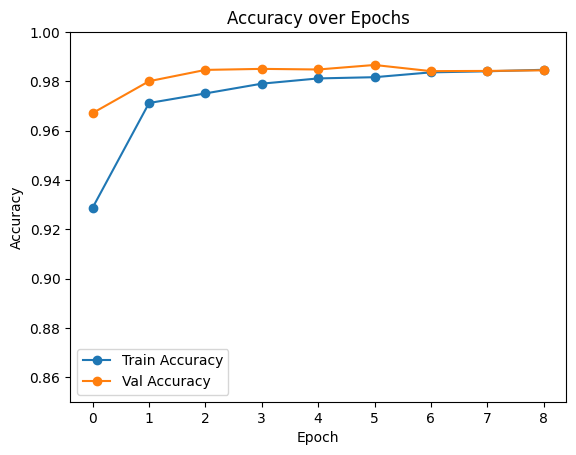

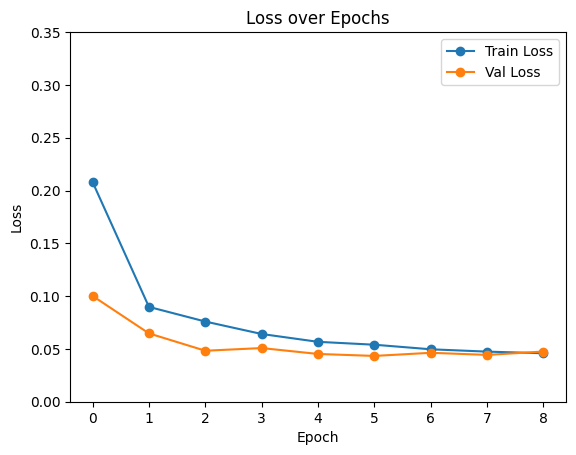

In [ ]:
# training time is so long that we have to interrupt the trainning process for the 2nd time of running the code after finishing report.
# but the result can be guaranteed to be same/similar as in the report
# of course, maybe not same as report, because the running result will not be STRICTLY same each time training deep learning model
# you can run the code to check result.


# dont use sequential
inputs = Input(shape=(28, 28, 1), name='input_layer')

x = Conv2D(32, (3,3), activation='relu', padding='same', name='conv1')(inputs)
x = MaxPooling2D((2,2), name='pool1')(x)
x = Dropout(0.25, name='dropout1')(x)

x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2,2), name='pool2')(x)
x = Dropout(0.25, name='dropout2')(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv3')(x)
x = Dropout(0.3, name='dropout3')(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv4')(x)
x = MaxPooling2D((2,2), name='pool4')(x)
x = Dropout(0.3, name='dropout4')(x)

x = Flatten(name='flatten')(x)

x = Dense(512, activation='relu', name='dense_512')(x)
x = Dropout(0.5, name='dropout5')(x)

encoded = Dense(256, activation='relu', name='encoding_layer')(x)

outputs = Dense(5, activation='softmax', name='output_layer')(encoded)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

display(model.summary())



early_stop = EarlyStopping(
    monitor='val_loss',         # 监控验证集上的loss
    patience=3,                 # 如果3个epoch内val_loss没有下降，则停止训练
    restore_best_weights=True  # 自动恢复到val_loss最小的模型权重
)
checkpoint_path = '/content/drive/MyDrive/ece657A3/best_base_model.keras'  #
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    # X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)



# 6. residual block

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 14, 14, 32)     │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 14, 14, 32)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 7, 7, 64)       │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 7, 7, 64)       │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 7, 7, 128)      │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 7, 7, 128)      │              0 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 7, 7, 128)      │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 7, 7, 128)      │          8,320 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 7, 7, 128)      │              0 │ conv2d_13[0][0],       │
│                           │                        │                │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 3, 3, 128)      │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 3, 3, 128)      │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 1152)           │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 512)            │        590,336 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 512)            │              0 │ dense_10[0][0]         │
├──────────────────────

 Total params: 971,525 (3.71 MB)

 Trainable params: 971,525 (3.71 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8595 - loss: 0.3780 - val_accuracy: 0.9676 - val_loss: 0.1012
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9708 - loss: 0.0932 - val_accuracy: 0.9836 - val_loss: 0.0538
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9786 - loss: 0.0646 - val_accuracy: 0.9839 - val_loss: 0.0506
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9797 - loss: 0.0602 - val_accuracy: 0.9830 - val_loss: 0.0493
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9819 - loss: 0.0554 - val_accuracy: 0.9861 - val_loss: 0.0419
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9814 - loss: 0.0517 - val_accuracy: 0.9861 - val_loss: 0.0421
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9851 - loss: 0.0448 - val_accuracy: 0.9865 - val_loss: 0.0431
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9854 - loss: 0.0439 - val_accuracy: 0

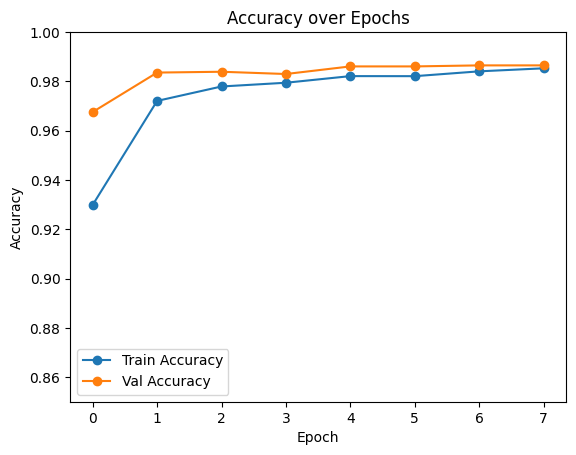

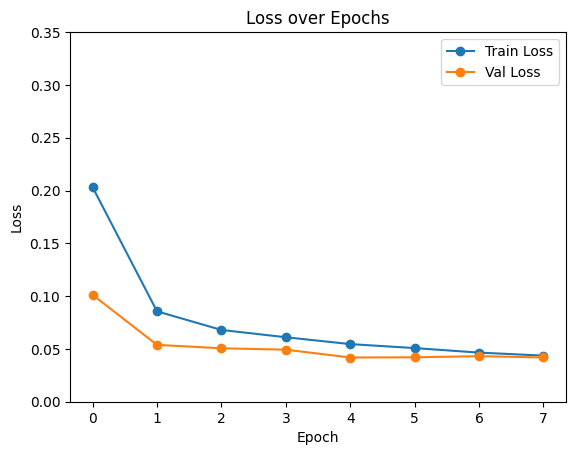

In [ ]:


## model residual
# 输入层
input_layer = Input(shape=(28, 28, 1))

# 卷积层1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# 卷积层2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# ➕ 残差块（residual block）
res_input = x  # 残差块输入

res = Conv2D(128, (3,3), activation='relu', padding='same')(res_input)
res = Dropout(0.3)(res)
res = Conv2D(128, (3,3), activation='relu', padding='same')(res)

# shortcut路径：用1x1 conv调整通道数, if no, will 64, cannot add res
shortcut = Conv2D(128, (1,1), padding='same')(res_input)
# 残差加法：输入 + 输出
res_out = Add()([res, shortcut])  # res_out shape: (7,7,128)

# 卷积层后继续处理
x = MaxPooling2D((2,2))(res_out)
x = Dropout(0.3)(x)

# 全连接层
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)

# 模型构建
model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
display(model.summary())


early_stop = EarlyStopping(
    monitor='val_loss',         # 监控验证集上的loss
    patience=3,                 # 如果3个epoch内val_loss没有下降，则停止训练
    restore_best_weights=True  # 自动恢复到val_loss最小的模型权重
)
checkpoint_path = '/content/drive/MyDrive/ece657A3/best_base_model.keras'  # ✅ 改成新版格式
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)



start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    # X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)


# 7. data augmentation

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout4 (Dropout)                   │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout5 (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoding_layer (Dense)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 963,205 (3.67 MB)

 Trainable params: 963,205 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8869 - loss: 0.3091 - val_accuracy: 0.9772 - val_loss: 0.0677
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9726 - loss: 0.0838 - val_accuracy: 0.9825 - val_loss: 0.0545
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9789 - loss: 0.0664 - val_accuracy: 0.9852 - val_loss: 0.0428
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9801 - loss: 0.0592 - val_accuracy: 0.9845 - val_loss: 0.0467
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9824 - loss: 0.0546 - val_accuracy: 0.9836 - val_loss: 0.0469
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9837 - loss: 0.0503 - val_accuracy: 0.9859 - val_loss: 0.0435

⏱ Training time: 59.42 seconds

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9867 - loss: 0.0496
Test Accuracy: 0.9862


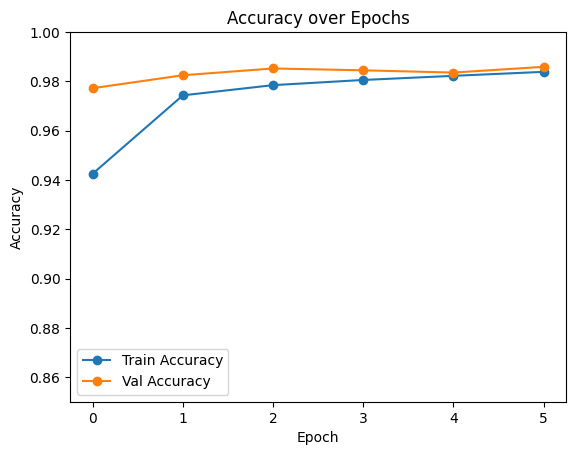

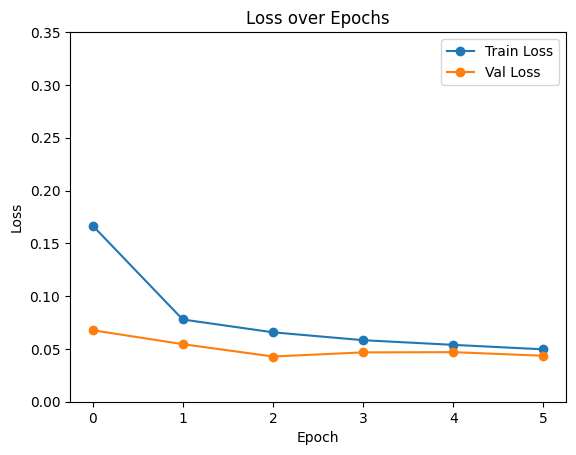

In [ ]:

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True
# )
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
)


datagen.fit(X_train)  # 训练数据增强



# dont use sequential
# 输入层
inputs = Input(shape=(28, 28, 1), name='input_layer')

# 卷积+池化1
x = Conv2D(32, (3,3), activation='relu', padding='same', name='conv1')(inputs)
x = MaxPooling2D((2,2), name='pool1')(x)
x = Dropout(0.25, name='dropout1')(x)

# 卷积+池化2
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2,2), name='pool2')(x)
x = Dropout(0.25, name='dropout2')(x)

# 卷积3
x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv3')(x)
x = Dropout(0.3, name='dropout3')(x)

# 卷积+池化4
x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv4')(x)
x = MaxPooling2D((2,2), name='pool4')(x)
x = Dropout(0.3, name='dropout4')(x)

# 展平层
x = Flatten(name='flatten')(x)

# 全连接层 Dense(512)
x = Dense(512, activation='relu', name='dense_512')(x)
x = Dropout(0.5, name='dropout5')(x)

# 中间特征编码层 Dense(256)
encoded = Dense(256, activation='relu', name='encoding_layer')(x)

# 输出层
outputs = Dense(5, activation='softmax', name='output_layer')(encoded)

# 建立模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 查看模型结构
display(model.summary())



early_stop = EarlyStopping(
    monitor='val_loss',         # 监控验证集上的loss
    patience=3,                 # 如果3个epoch内val_loss没有下降，则停止训练
    restore_best_weights=True  # 自动恢复到val_loss最小的模型权重
)
checkpoint_path = '/content/drive/MyDrive/ece657A3/best_base_model.keras'  # ✅ 改成新版格式
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)


augmented_X, augmented_y = next(datagen.flow(X_train, y_train_cat, batch_size=len(X_train)))
# 拼接原图和增强图
X_mixed = np.concatenate((X_train, augmented_X), axis=0)
y_mixed = np.concatenate((y_train_cat, augmented_y), axis=0)

start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    # X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)


# Part II best model from above

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout4 (Dropout)                   │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout5 (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoding_layer (Dense)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 963,205 (3.67 MB)

 Trainable params: 963,205 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8555 - loss: 0.3834 - val_accuracy: 0.9758 - val_loss: 0.0740
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9697 - loss: 0.0960 - val_accuracy: 0.9810 - val_loss: 0.0584
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9759 - loss: 0.0733 - val_accuracy: 0.9800 - val_loss: 0.0579
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9799 - loss: 0.0651 - val_accuracy: 0.9847 - val_loss: 0.0480
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9813 - loss: 0.0546 - val_accuracy: 0.9852 - val_loss: 0.0452
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9823 - loss: 0.0521 - val_accuracy: 0.9845 - val_loss: 0.0450
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9841 - loss: 0.0484 - val_accuracy: 0.9858 - val_loss: 0.0429
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9848 - loss: 0.0452 - val_accuracy: 0

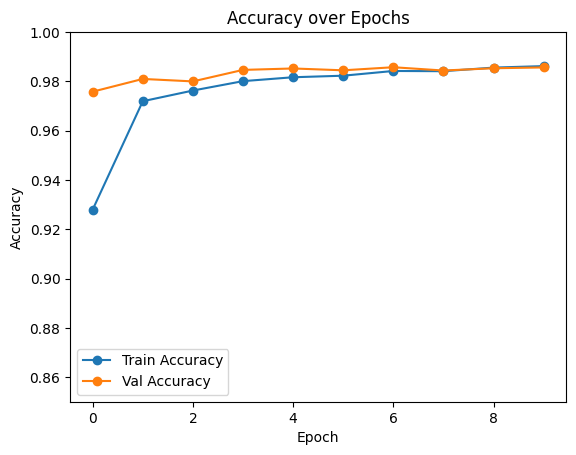

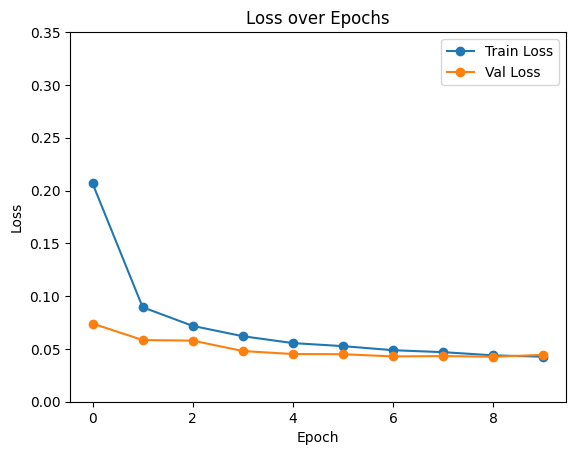

In [ ]:

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True
# )
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
)


datagen.fit(X_train)  # 训练数据增强



# # 构建模型
# model = Sequential()

# # 输入层 + 第一层卷积层
# model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
#                  activation='relu', input_shape=(28,28,1)))

# # 第一层池化层
# model.add(MaxPooling2D(pool_size=(2,2)))

# # 第二层卷积层
# model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# # Flatten展平
# model.add(Flatten())

# # 全连接层：512个节点
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))

# # 输出层：5分类 + softmax
# model.add(Dense(5, activation='softmax'))

# # 编译模型
# model.compile(
#     # optimizer=optimizers.SGD(),
#               optimizer=optimizers.Adam(),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # 打印模型结构
# display(model.summary())


# ## add conv
# model = Sequential([
#     # 卷积层1 + 池化
#     Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
#     MaxPooling2D((2,2)),
#     Dropout(0.25),

#     # 卷积层2 + 池化
#     Conv2D(64, (3,3), activation='relu', padding='same'),
#     MaxPooling2D((2,2)),
#     Dropout(0.25),

#     # 卷积层3（不一定需要池化）
#     Conv2D(128, (3,3), activation='relu', padding='same'),
#     Dropout(0.3),

#     # 卷积层4（再深一层）
#     Conv2D(128, (3,3), activation='relu', padding='same'),
#     MaxPooling2D((2,2)),
#     Dropout(0.3),

#     # 展平 + 全连接层
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     Dense(5, activation='softmax')  # 5类分类问题
# ])

# model.compile(
#     optimizer=optimizers.Adam(),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# display(model.summary())

# dont use sequential
# 输入层
inputs = Input(shape=(28, 28, 1), name='input_layer')

# 卷积+池化1
x = Conv2D(32, (3,3), activation='relu', padding='same', name='conv1')(inputs)
x = MaxPooling2D((2,2), name='pool1')(x)
x = Dropout(0.25, name='dropout1')(x)

# 卷积+池化2
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2,2), name='pool2')(x)
x = Dropout(0.25, name='dropout2')(x)

# 卷积3
x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv3')(x)
x = Dropout(0.3, name='dropout3')(x)

# 卷积+池化4
x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv4')(x)
x = MaxPooling2D((2,2), name='pool4')(x)
x = Dropout(0.3, name='dropout4')(x)

# 展平层
x = Flatten(name='flatten')(x)

# 全连接层 Dense(512)
x = Dense(512, activation='relu', name='dense_512')(x)
x = Dropout(0.5, name='dropout5')(x)

# 中间特征编码层 Dense(256)
encoded = Dense(256, activation='relu', name='encoding_layer')(x)

# 输出层
outputs = Dense(5, activation='softmax', name='output_layer')(encoded)

# 建立模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 查看模型结构
display(model.summary())



# ## model residual
# # 输入层
# input_layer = Input(shape=(28, 28, 1))

# # 卷积层1
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.25)(x)

# # 卷积层2
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.25)(x)

# # ➕ 残差块（residual block）
# res_input = x  # 残差块输入

# res = Conv2D(128, (3,3), activation='relu', padding='same')(res_input)
# res = Dropout(0.3)(res)
# res = Conv2D(128, (3,3), activation='relu', padding='same')(res)

# # shortcut路径：用1x1 conv调整通道数, if no, will 64, cannot add res
# shortcut = Conv2D(128, (1,1), padding='same')(res_input)
# # 残差加法：输入 + 输出
# res_out = Add()([res, shortcut])  # res_out shape: (7,7,128)

# # 卷积层后继续处理
# x = MaxPooling2D((2,2))(res_out)
# x = Dropout(0.3)(x)

# # 全连接层
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# output_layer = Dense(5, activation='softmax')(x)

# # 模型构建
# model = Model(inputs=input_layer, outputs=output_layer)

# # 编译模型
# model.compile(
#     optimizer=optimizers.Adam(),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
# display(model.summary())


early_stop = EarlyStopping(
    monitor='val_loss',         # 监控验证集上的loss
    patience=3,                 # 如果3个epoch内val_loss没有下降，则停止训练
    restore_best_weights=True  # 自动恢复到val_loss最小的模型权重
)
checkpoint_path = '/content/drive/MyDrive/ece657A3/updated_each_time_best_model.keras'  # ✅ 改成新版格式
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)


# augmented_X, augmented_y = next(datagen.flow(X_train, y_train_cat, batch_size=len(X_train)))
# # 拼接原图和增强图
# X_mixed = np.concatenate((X_train, augmented_X), axis=0)
# y_mixed = np.concatenate((y_train_cat, augmented_y), axis=0)

start_time = time.time()

history = model.fit(
    # datagen.flow(X_train, y_train_cat, batch_size=64),# data augmentation 1
    # X_mixed, y_mixed, batch_size=64, # # data augmentation 2
    X_train, y_train_cat, batch_size=64,     # 常见的batch大小
    validation_data=(X_val, y_val_cat),
    # validation_split=0.2,
    epochs=10,         # 可调成20或30
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱ Training time: {training_time:.2f} seconds")
print()

# default bs = 32
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")



# Accuracy 曲线（加点）
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss 曲线（加点）
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# model = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')
# model.evaluate(...)
# model.predict(...)


# Classic models: just try

## classical model1: googlenet

/content/drive/MyDrive/ece657A3/classmodels/googlenet.py:73: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


Epoch 1 - Train Acc: 0.9385 - Val Acc: 0.9718 - Train Loss: 0.2010 - Val Loss: 0.0984
Epoch 2 - Train Acc: 0.9687 - Val Acc: 0.9664 - Train Loss: 0.1116 - Val Loss: 0.1138
Epoch 3 - Train Acc: 0.9757 - Val Acc: 0.9774 - Train Loss: 0.0846 - Val Loss: 0.0788
Epoch 4 - Train Acc: 0.9762 - Val Acc: 0.9716 - Train Loss: 0.0797 - Val Loss: 0.0948
Epoch 5 - Train Acc: 0.9781 - Val Acc: 0.9764 - Train Loss: 0.0767 - Val Loss: 0.0801
Epoch 6 - Train Acc: 0.9809 - Val Acc: 0.9812 - Train Loss: 0.0641 - Val Loss: 0.0680
Epoch 7 - Train Acc: 0.9815 - Val Acc: 0.9760 - Train Loss: 0.0627 - Val Loss: 0.0991
Epoch 8 - Train Acc: 0.9846 - Val Acc: 0.9846 - Train Loss: 0.0488 - Val Loss: 0.0517
Epoch 9 - Train Acc: 0.9861 - Val Acc: 0.9811 - Train Loss: 0.0463 - Val Loss: 0.0610
Epoch 10 - Train Acc: 0.9851 - Val Acc: 0.9808 - Train Loss: 0.0478 - Val Loss: 0.0613
Test Accuracy: 0.9813


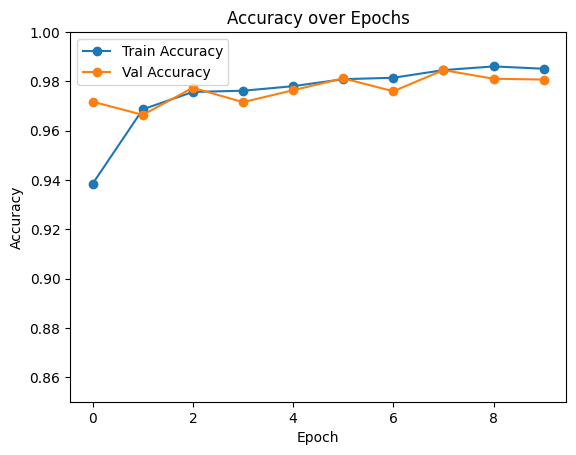

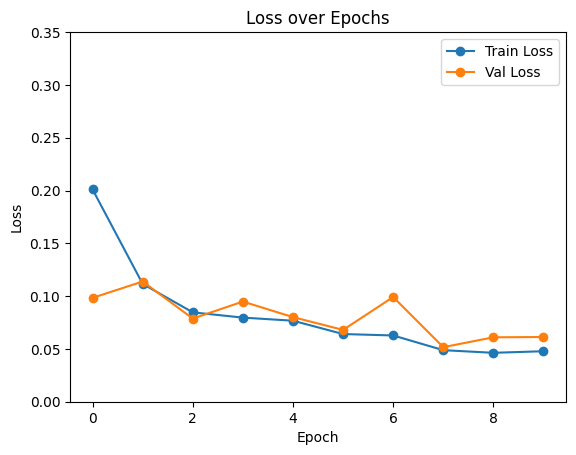

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=3, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_score = float('inf') if monitor == 'val_loss' else -float('inf')
        self.patience_counter = 0
        self.best_state_dict = None
        self.early_stop = False

    def step(self, current_score, model):
        # 判断是否为提升
        if (self.monitor == 'val_loss' and current_score < self.best_score) or \
           (self.monitor == 'val_acc' and current_score > self.best_score):
            self.best_score = current_score
            self.patience_counter = 0
            if self.restore_best_weights:
                self.best_state_dict = model.state_dict()
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print(f"EarlyStopping triggered on {self.monitor}.")
                self.early_stop = True

    def restore_best_weights_to(self, model):
        if self.restore_best_weights and self.best_state_dict:
            model.load_state_dict(self.best_state_dict)


# 数据预处理
X_train_torch = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_val_torch = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_test_torch = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)

y_train_torch = torch.tensor(np.argmax(y_train_cat, axis=1), dtype=torch.long)
y_val_torch = torch.tensor(np.argmax(y_val_cat, axis=1), dtype=torch.long)
y_test_torch = torch.tensor(np.argmax(y_test_cat, axis=1), dtype=torch.long)

# 构建 DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size)

# 模型导入
from googlenet import GoogLeNet  # 请确保 googlenet.py 存在
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GoogLeNet(num_classes=5, aux_logits=True).to(device)

# 损失与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ 训练：加上验证 + EarlyStopping
best_val_acc = 0.0
patience = 3
patience_counter = 0
best_model_state = None
epochs = 10
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_loss_avg = total_loss / len(train_loader)

    # ✅ 验证
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_loss_avg = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    # ✅ 存进 history（模拟 Keras）
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    history['loss'].append(train_loss_avg)
    history['val_loss'].append(val_loss_avg)

    # ✅ early stopping
    early_stopper.step(val_loss_avg, model)
    if early_stopper.early_stop:
        break


# ✅ 恢复最佳权重
early_stopper.restore_best_weights_to(model)


# ✅ 测试集评估
model.eval()
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


# Accuracy
plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1 - Train Acc: 0.9490 - Val Acc: 0.9761 - Train Loss: 0.1724 - Val Loss: 0.0864
Epoch 2 - Train Acc: 0.9741 - Val Acc: 0.9782 - Train Loss: 0.0894 - Val Loss: 0.0677
Epoch 3 - Train Acc: 0.9777 - Val Acc: 0.9799 - Train Loss: 0.0746 - Val Loss: 0.0703
Epoch 4 - Train Acc: 0.9809 - Val Acc: 0.9807 - Train Loss: 0.0624 - Val Loss: 0.0643
Epoch 5 - Train Acc: 0.9833 - Val Acc: 0.9832 - Train Loss: 0.0551 - Val Loss: 0.0583
Epoch 6 - Train Acc: 0.9855 - Val Acc: 0.9848 - Train Loss: 0.0465 - Val Loss: 0.0462
Epoch 7 - Train Acc: 0.9869 - Val Acc: 0.9805 - Train Loss: 0.0403 - Val Loss: 0.0627
Epoch 8 - Train Acc: 0.9882 - Val Acc: 0.9844 - Train Loss: 0.0376 - Val Loss: 0.0508
Epoch 9 - Train Acc: 0.9892 - Val Acc: 0.9863 - Train Loss: 0.0338 - Val Loss: 0.0454
Epoch 10 - Train Acc: 0.9900 - Val Acc: 0.9842 - Train Loss: 0.0309 - Val Loss: 0.0478
Test Accuracy: 0.9861


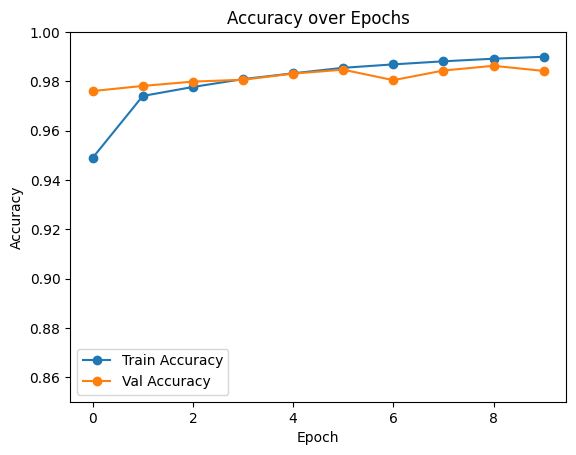

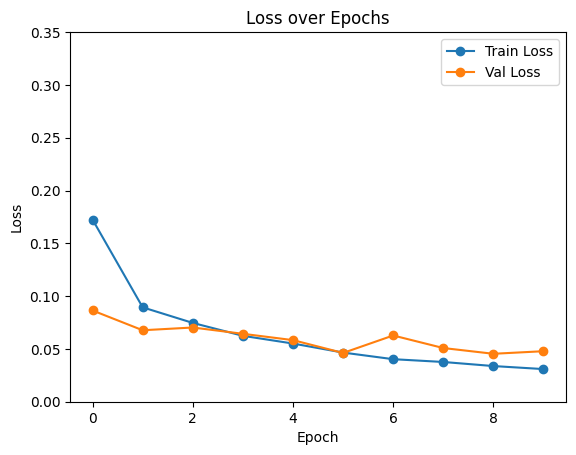

In [ ]:
# 数据增广
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True
# )
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
)

augmented_X, augmented_y = next(datagen.flow(X_train, y_train_cat, batch_size=len(X_train)))
# 拼接原图和增强图
X_mixed = np.concatenate((X_train, augmented_X), axis=0)
y_mixed = np.concatenate((y_train_cat, augmented_y), axis=0)



class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=3, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_score = float('inf') if monitor == 'val_loss' else -float('inf')
        self.patience_counter = 0
        self.best_state_dict = None
        self.early_stop = False

    def step(self, current_score, model):
        # 判断是否为提升
        if (self.monitor == 'val_loss' and current_score < self.best_score) or \
           (self.monitor == 'val_acc' and current_score > self.best_score):
            self.best_score = current_score
            self.patience_counter = 0
            if self.restore_best_weights:
                self.best_state_dict = model.state_dict()
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print(f"EarlyStopping triggered on {self.monitor}.")
                self.early_stop = True

    def restore_best_weights_to(self, model):
        if self.restore_best_weights and self.best_state_dict:
            model.load_state_dict(self.best_state_dict)


# 数据预处理
X_train_torch = torch.tensor(X_mixed.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)

# X_train_torch = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_val_torch = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_test_torch = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)


y_train_torch = torch.tensor(np.argmax(y_mixed, axis=1), dtype=torch.long)
# y_train_torch = torch.tensor(np.argmax(y_train_cat, axis=1), dtype=torch.long)
y_val_torch = torch.tensor(np.argmax(y_val_cat, axis=1), dtype=torch.long)
y_test_torch = torch.tensor(np.argmax(y_test_cat, axis=1), dtype=torch.long)

# 构建 DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size)

# 模型导入
from googlenet import GoogLeNet  # 请确保 googlenet.py 存在
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GoogLeNet(num_classes=5, aux_logits=True).to(device)

# 损失与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ 训练：加上验证 + EarlyStopping
best_val_acc = 0.0
patience = 3
patience_counter = 0
best_model_state = None
epochs = 10
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_loss_avg = total_loss / len(train_loader)

    # ✅ 验证
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_loss_avg = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    # ✅ 存进 history（模拟 Keras）
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    history['loss'].append(train_loss_avg)
    history['val_loss'].append(val_loss_avg)

    # ✅ early stopping
    early_stopper.step(val_loss_avg, model)
    if early_stopper.early_stop:
        break


# ✅ 恢复最佳权重
early_stopper.restore_best_weights_to(model)


# ✅ 测试集评估
model.eval()
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


# Accuracy
plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Val Accuracy', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.ylim(0, 0.35)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## classcial model2: resnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 | Train Loss: 96.8852 Acc: 0.9590 | Val Loss: 16.4467 Acc: 0.9719
Epoch 2 | Train Loss: 55.9959 Acc: 0.9761 | Val Loss: 11.5958 Acc: 0.9793
Epoch 3 | Train Loss: 45.7431 Acc: 0.9804 | Val Loss: 11.8291 Acc: 0.9794
Epoch 4 | Train Loss: 39.4758 Acc: 0.9827 | Val Loss: 12.3920 Acc: 0.9783
Epoch 5 | Train Loss: 33.5355 Acc: 0.9848 | Val Loss: 10.7056 Acc: 0.9822
Epoch 6 | Train Loss: 31.9614 Acc: 0.9862 | Val Loss: 10.5616 Acc: 0.9804
Epoch 7 | Train Loss: 27.3894 Acc: 0.9872 | Val Loss: 10.5879 Acc: 0.9826
Epoch 8 | Train Loss: 25.2988 Acc: 0.9888 | Val Loss: 11.0147 Acc: 0.9800
Epoch 9 | Train Loss: 22.4762 Acc: 0.9895 | Val Loss: 9.2042 Acc: 0.9844
Epoch 10 | Train Loss: 18.7181 Acc: 0.9911 | Val Loss: 11.3941 Acc: 0.9797
Test Accuracy: 0.9846


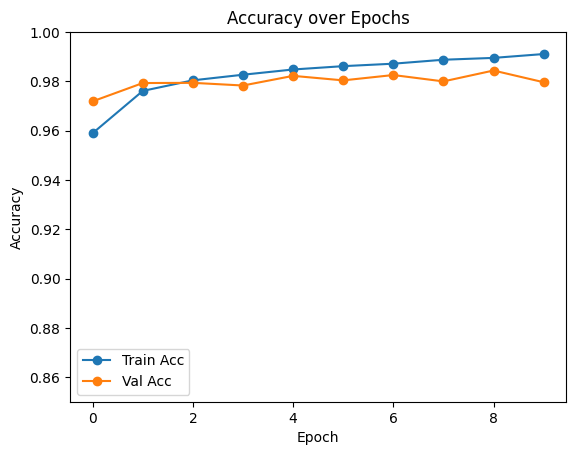

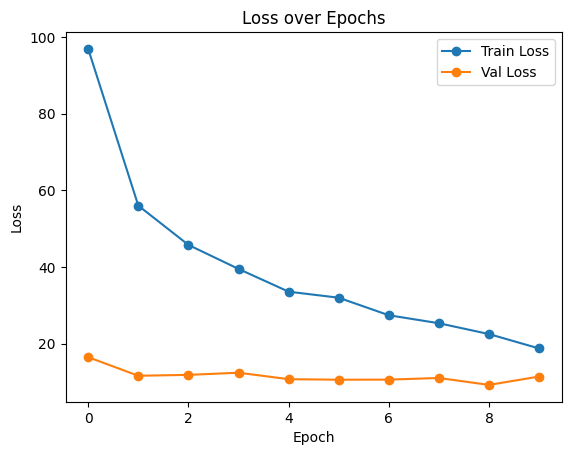

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet18
import copy

# ✅ EarlyStopping 实现
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.best_model is not None:
            model.load_state_dict(self.best_model)

# ✅ 数据预处理（你已有的数据）
# X_train, X_val, X_test: (N, 28, 28, 1)
# y_train_cat, y_val_cat, y_test_cat: one-hot

X_train_torch = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_val_torch   = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_test_torch  = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)

y_train_torch = torch.tensor(np.argmax(y_train_cat, axis=1), dtype=torch.long)
y_val_torch   = torch.tensor(np.argmax(y_val_cat, axis=1), dtype=torch.long)
y_test_torch  = torch.tensor(np.argmax(y_test_cat, axis=1), dtype=torch.long)

# ✅ 构建 DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size)

# ✅ 模型定义 + 训练设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stop = EarlyStopping(patience=3)

# ✅ 模型训练 + 验证 + 早停
epochs = 10
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model.train()
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = correct / len(train_loader.dataset)

    # 验证
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if early_stop.step(val_loss, model):
        print("Early stopping triggered!")
        break

# ✅ 恢复最佳模型
early_stop.restore(model)

# ✅ 测试集评估
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# ✅ 绘制 Accuracy & Loss 曲线
plt.plot(history['train_acc'], label='Train Acc', marker='o')
plt.plot(history['val_acc'], label='Val Acc', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1 | Train Loss: 174.5482 Acc: 0.9625 | Val Loss: 13.7579 Acc: 0.9752
Epoch 2 | Train Loss: 98.7136 Acc: 0.9780 | Val Loss: 16.6193 Acc: 0.9732
Epoch 3 | Train Loss: 80.3988 Acc: 0.9818 | Val Loss: 10.9255 Acc: 0.9799
Epoch 4 | Train Loss: 68.4172 Acc: 0.9846 | Val Loss: 9.2074 Acc: 0.9830
Epoch 5 | Train Loss: 57.4962 Acc: 0.9867 | Val Loss: 9.5820 Acc: 0.9831
Epoch 6 | Train Loss: 50.8266 Acc: 0.9880 | Val Loss: 8.4759 Acc: 0.9852
Epoch 7 | Train Loss: 42.1971 Acc: 0.9904 | Val Loss: 9.5332 Acc: 0.9842
Epoch 8 | Train Loss: 37.4011 Acc: 0.9914 | Val Loss: 8.8566 Acc: 0.9861
Epoch 9 | Train Loss: 34.1476 Acc: 0.9920 | Val Loss: 8.9771 Acc: 0.9868
Early stopping triggered!
Test Accuracy: 0.9865


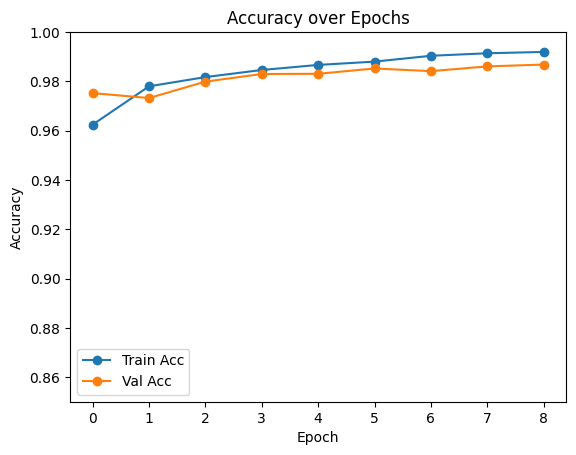

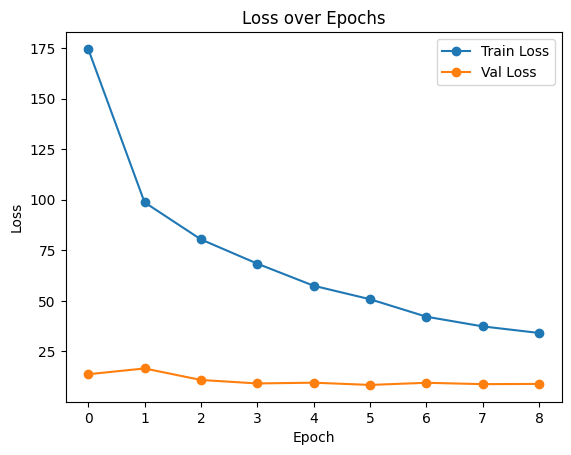

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet18
import copy

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True
# )
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
)

# ✅ EarlyStopping 实现
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.best_model is not None:
            model.load_state_dict(self.best_model)

# 数据预处理
X_train_torch = torch.tensor(X_mixed.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)

# X_train_torch = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_val_torch = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)
X_test_torch = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32).repeat(1, 3, 1, 1)


y_train_torch = torch.tensor(np.argmax(y_mixed, axis=1), dtype=torch.long)
# y_train_torch = torch.tensor(np.argmax(y_train_cat, axis=1), dtype=torch.long)
y_val_torch = torch.tensor(np.argmax(y_val_cat, axis=1), dtype=torch.long)
y_test_torch = torch.tensor(np.argmax(y_test_cat, axis=1), dtype=torch.long)


# ✅ 构建 DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size)

# ✅ 模型定义 + 训练设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stop = EarlyStopping(patience=3)

# ✅ 模型训练 + 验证 + 早停
epochs = 10
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model.train()
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = correct / len(train_loader.dataset)

    # 验证
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if early_stop.step(val_loss, model):
        print("Early stopping triggered!")
        break

# ✅ 恢复最佳模型
early_stop.restore(model)

# ✅ 测试集评估
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# ✅ 绘制 Accuracy & Loss 曲线
plt.plot(history['train_acc'], label='Train Acc', marker='o')
plt.plot(history['val_acc'], label='Val Acc', marker='o')
plt.ylim(0.85, 1.0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# model_loaded = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')

# # # 导出模型结构图（保存为 PNG）
# # plot_model(model_loaded,
# #            to_file='/content/drive/MyDrive/ece657A3/best_model_structure.png',  # ✅ 你可以改路径
# #            show_shapes=True,   # 显示每一层的 shape
# #            show_layer_names=True,  # 显示每一层的名字
# #            dpi=100)  # 图片分辨率，可调高
# plot_model(model_loaded,
#            to_file='/content/drive/MyDrive/ece657A3/best_model_structure.png',
#            show_shapes=True,
#            show_layer_names=True,
#            dpi=200,              # 提高清晰度
#           #  rankdir='LR'          # ⬅ 重点：Left-to-Right 排布（横向），让图变宽
# )

In [ ]:
model_loaded = load_model('/content/drive/MyDrive/ece657A3/best_model.keras')

# # 导出模型结构图（保存为 PNG）
# plot_model(model_loaded,
#            to_file='/content/drive/MyDrive/ece657A3/model_structure.png',  # ✅ 你可以改路径
#            show_shapes=True,   # 显示每一层的 shape
#            show_layer_names=True,  # 显示每一层的名字
#            dpi=100)  # 图片分辨率，可调高

intermediate_model = Model(
    inputs=model_loaded.input,
    outputs=model_loaded.get_layer('encoding_layer').output
)
X_encoded = intermediate_model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:

# # 不需要load_model，直接用训练好的 model 提取中间层输出
# intermediate_model = Model(inputs=model.input,
#                            outputs=model.get_layer('encoding_layer').output)

# X_encoded = intermediate_model.predict(X_test)
# print(X_encoded.shape)

## 1. PCA + kmeans/DBScan

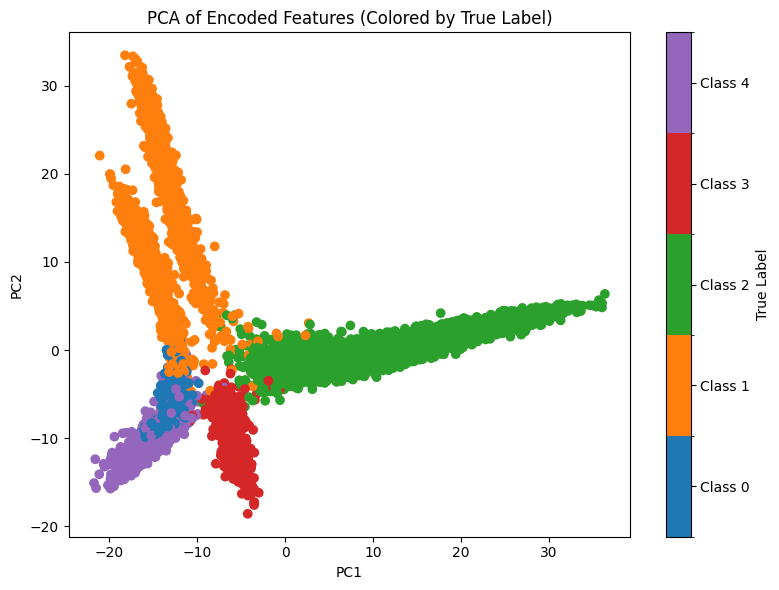

In [ ]:

# PCA降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# ✅ 自定义离散 colormap，只要前5种颜色（可换）
cmap = ListedColormap(plt.get_cmap('tab10').colors[:5])
norm = BoundaryNorm(boundaries=np.arange(6)-0.5, ncolors=5)

# 画图
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap=cmap, norm=norm)

# ✅ colorbar 离散处理
cbar = plt.colorbar(sc, ticks=np.arange(5))
cbar.set_label('True Label')
cbar.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])

# 标题和轴
plt.title("PCA of Encoded Features (Colored by True Label)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


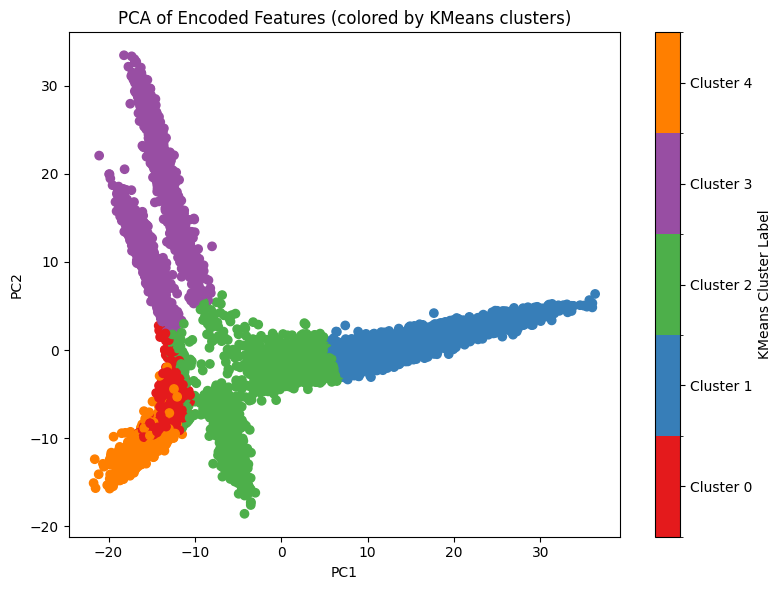

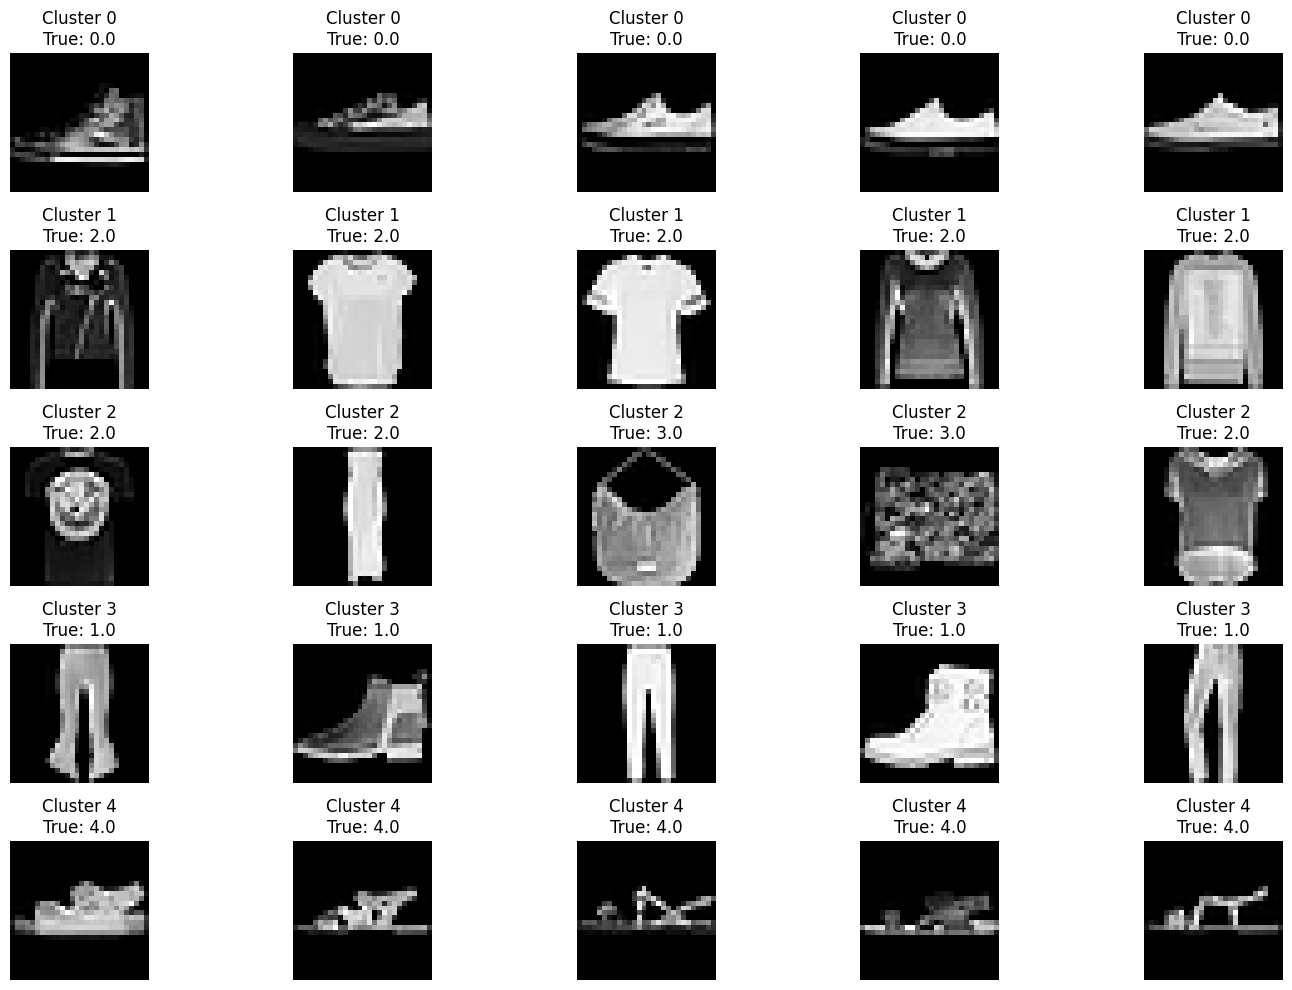

In [ ]:
# kmeans clustering

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_encoded)

# ✅ 自定义 colormap（5种离散颜色）
cmap = ListedColormap(plt.get_cmap('Set1').colors[:5])  # 可替换为 tab10, Dark2 等
norm = BoundaryNorm(boundaries=np.arange(6)-0.5, ncolors=5)

# 画图
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap=cmap, norm=norm)

# ✅ colorbar 离散化美化
cbar = plt.colorbar(sc, ticks=np.arange(5))
cbar.set_label('KMeans Cluster Label')
cbar.set_ticklabels([f'Cluster {i}' for i in range(5)])

plt.title("PCA of Encoded Features (colored by KMeans clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


# show pic of different clusters
n_per_cluster = 5  # 每个聚类显示几张图像

unique_clusters = np.unique(cluster_labels)

plt.figure(figsize=(15, len(unique_clusters)*2))

img_idx = 1
for cluster_id in unique_clusters:
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    n_select = min(n_per_cluster, len(cluster_indices))
    selected_indices = random.sample(list(cluster_indices), n_select)

    for i, idx in enumerate(selected_indices):
        plt.subplot(len(unique_clusters), n_per_cluster, img_idx)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Cluster {cluster_id}\nTrue: {y_test[idx]}')
        plt.axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()


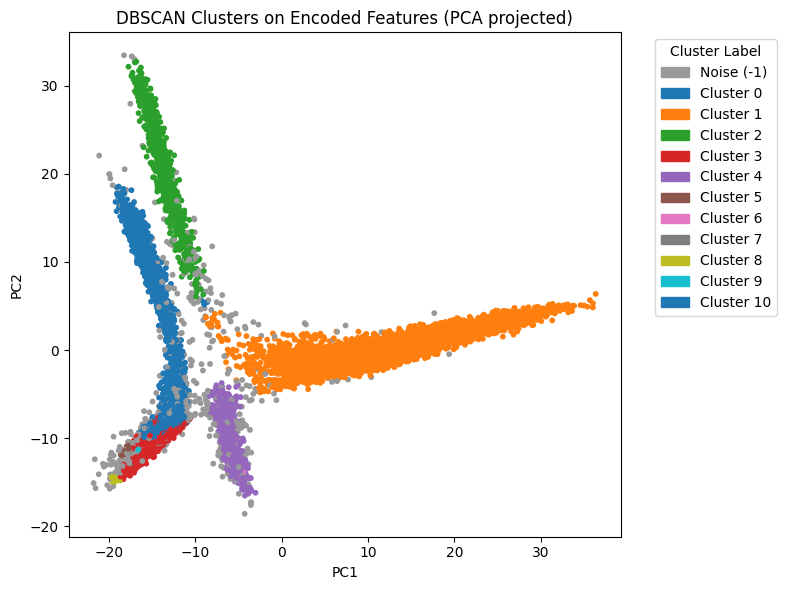

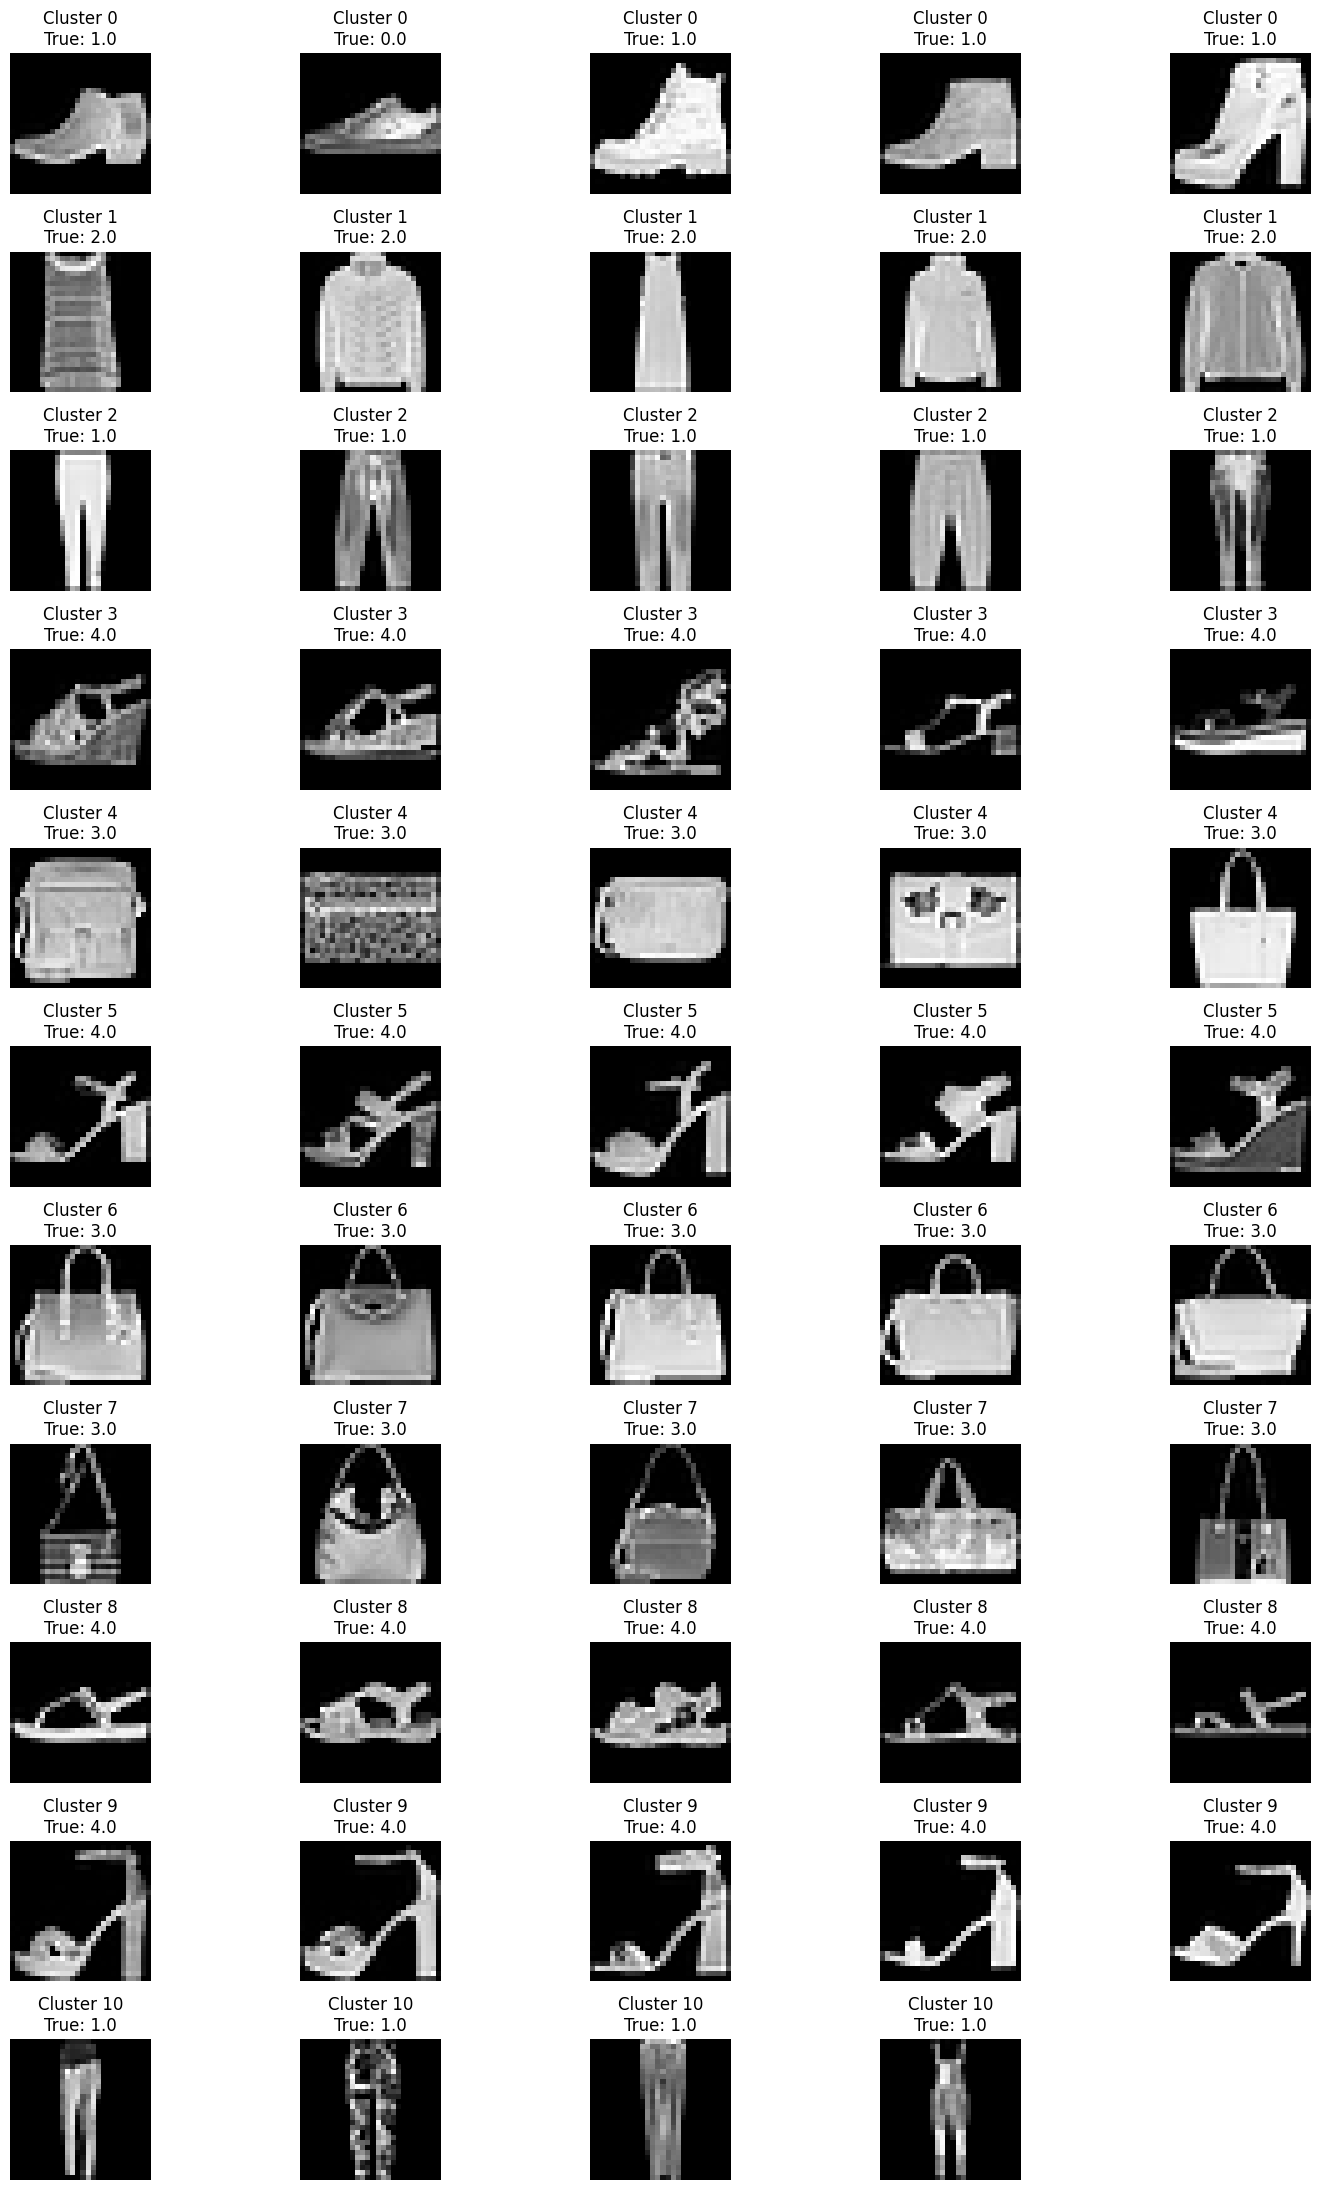

In [ ]:
# # DBSCAN clustering

dbscan = DBSCAN(eps=2.2, min_samples=6)
clusters = dbscan.fit_predict(X_encoded)

unique_labels = np.unique(clusters)
n_clusters = len(unique_labels)

# 自定义颜色映射，灰色给噪声 -1
colors = plt.cm.tab10.colors  # 或 Set1、Dark2 等
cmap_colors = []

for lbl in unique_labels:
    if lbl == -1:
        cmap_colors.append((0.6, 0.6, 0.6))  # 噪声灰色
    else:
        cmap_colors.append(colors[lbl % len(colors)])

cmap = ListedColormap(cmap_colors)

# 绘图
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap=cmap, s=10)

# 构造 legend 手动标注
handles = []
for idx, label in enumerate(unique_labels):
    if label == -1:
        patch = mpatches.Patch(color=cmap_colors[idx], label='Noise (-1)')
    else:
        patch = mpatches.Patch(color=cmap_colors[idx], label=f'Cluster {label}')
    handles.append(patch)

plt.legend(handles=handles, title="Cluster Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("DBSCAN Clusters on Encoded Features (PCA projected)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()



# show pics from each cluster
n_per_cluster = 5  # 每个cluster展示几张图像

# 只处理非噪声的 cluster（不显示 -1）
valid_clusters = [lbl for lbl in unique_labels if lbl != -1]

plt.figure(figsize=(15, len(valid_clusters)*2))

img_idx = 1
for cluster_id in valid_clusters:
    cluster_indices = np.where(clusters == cluster_id)[0]
    n_select = min(n_per_cluster, len(cluster_indices))
    selected_indices = random.sample(list(cluster_indices), n_select)

    for i, idx in enumerate(selected_indices):
        plt.subplot(len(valid_clusters), n_per_cluster, img_idx)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Cluster {cluster_id}\nTrue: {y_test[idx]}')
        plt.axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()


## 2. t-SNE + kmeans/DBScan

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


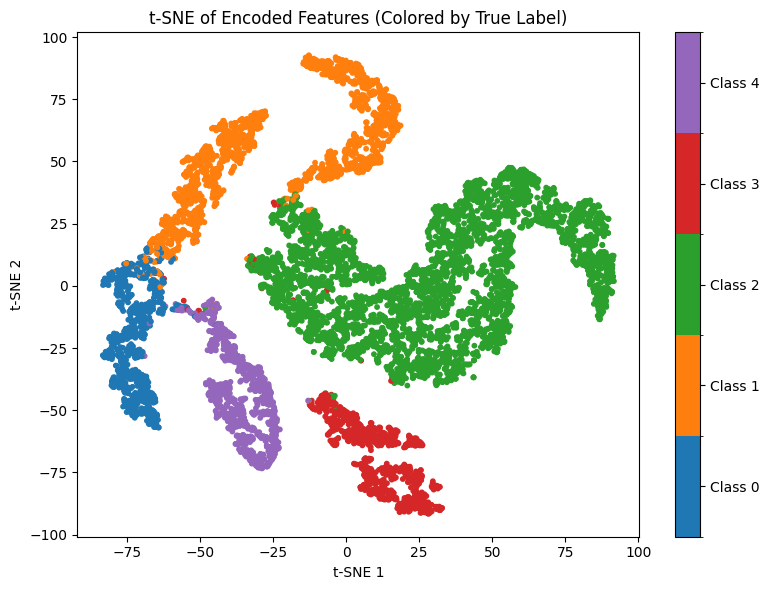

In [ ]:


# t-SNE 降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_encoded)

# ✅ 自定义离散 colormap，确保前 5 种颜色
cmap = ListedColormap(plt.get_cmap('tab10').colors[:5])
norm = BoundaryNorm(boundaries=np.arange(6)-0.5, ncolors=5)

# 绘制 t-SNE 结果
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap=cmap, norm=norm, s=10)

# ✅ colorbar 离散处理
cbar = plt.colorbar(sc, ticks=np.arange(5))
# cbar.set_label('True Label')
cbar.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])

# 标题和轴
plt.title("t-SNE of Encoded Features (Colored by True Label)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


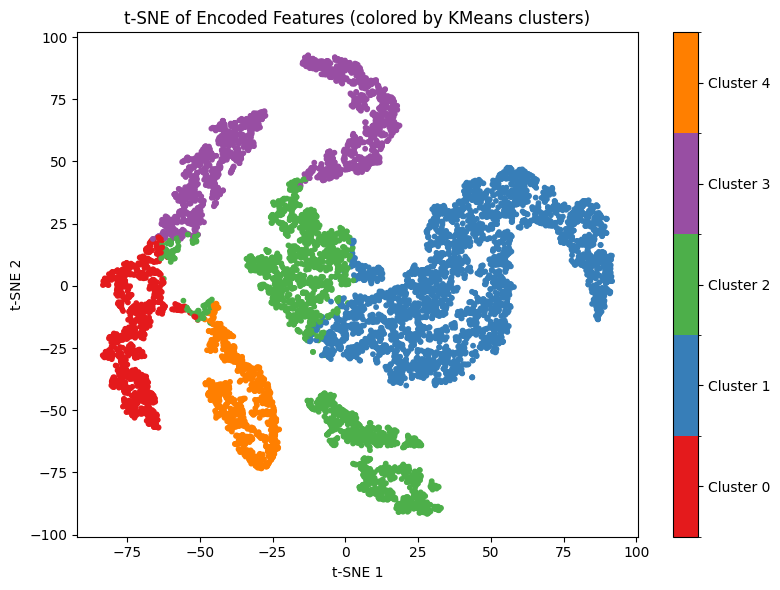

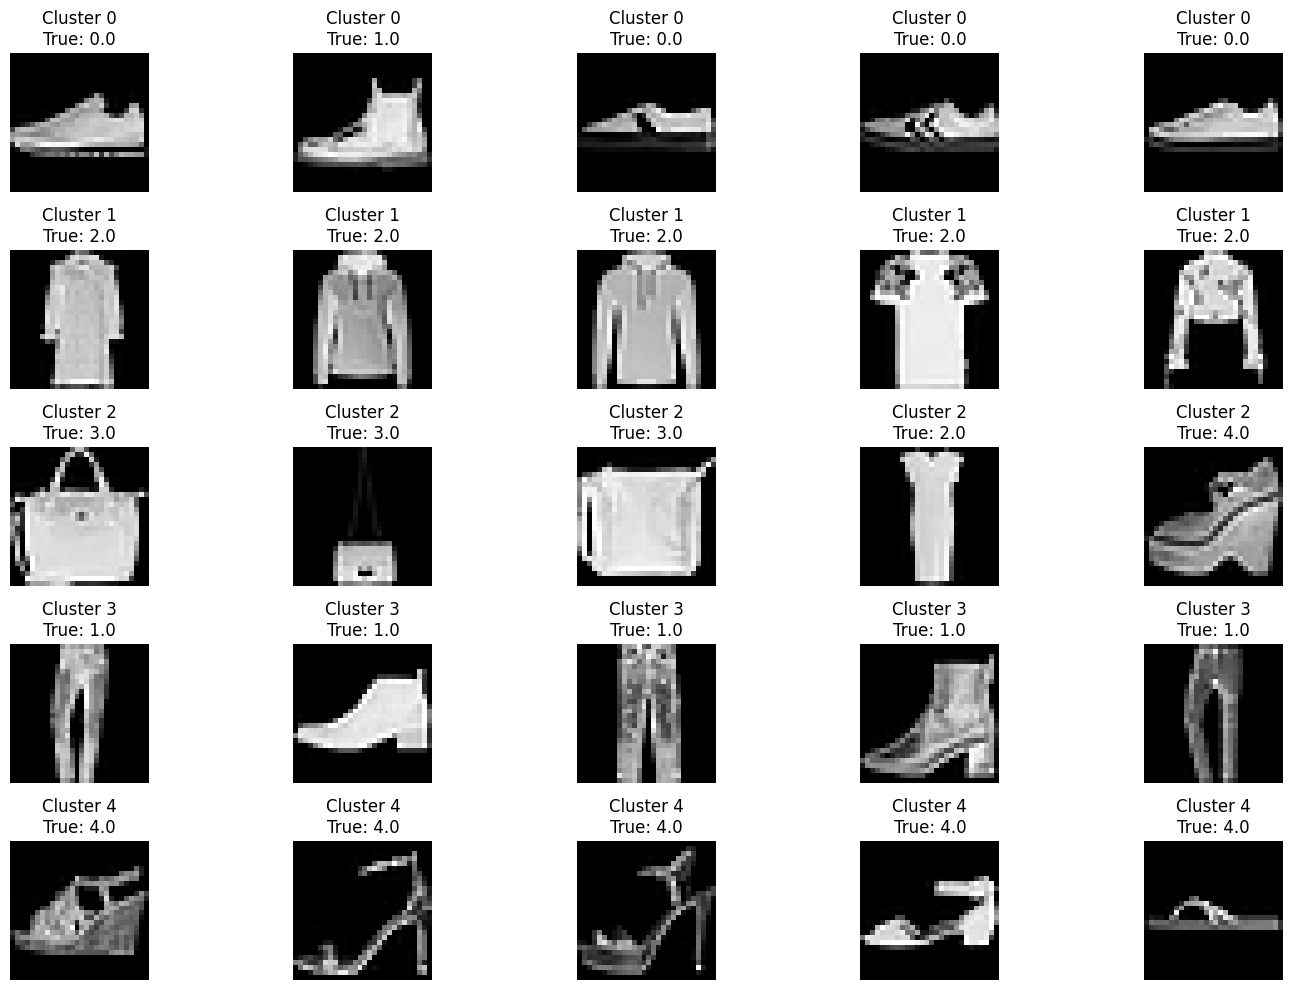

In [ ]:
# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_encoded)

# ✅ 自定义 colormap（5种离散颜色）
cmap = ListedColormap(plt.get_cmap('Set1').colors[:5])
norm = BoundaryNorm(boundaries=np.arange(6)-0.5, ncolors=5)

# t-SNE 可视化
plt.figure(figsize=(8,6))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap=cmap, norm=norm, s=10)

# ✅ 离散 colorbar 替代 legend
cbar = plt.colorbar(sc, ticks=np.arange(5))
# cbar.set_label('KMeans Cluster Label')
cbar.set_ticklabels([f'Cluster {i}' for i in range(5)])

plt.title("t-SNE of Encoded Features (colored by KMeans clusters)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

# ✅ 每个聚类显示若干图像
n_per_cluster = 5  # 每个聚类展示几张图
unique_clusters = np.unique(cluster_labels)

plt.figure(figsize=(15, len(unique_clusters)*2))

img_idx = 1
for cluster_id in unique_clusters:
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    n_select = min(n_per_cluster, len(cluster_indices))
    selected_indices = random.sample(list(cluster_indices), n_select)

    for idx in selected_indices:
        plt.subplot(len(unique_clusters), n_per_cluster, img_idx)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Cluster {cluster_id}\nTrue: {y_test[idx]}')
        plt.axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()


DBSCAN cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10]


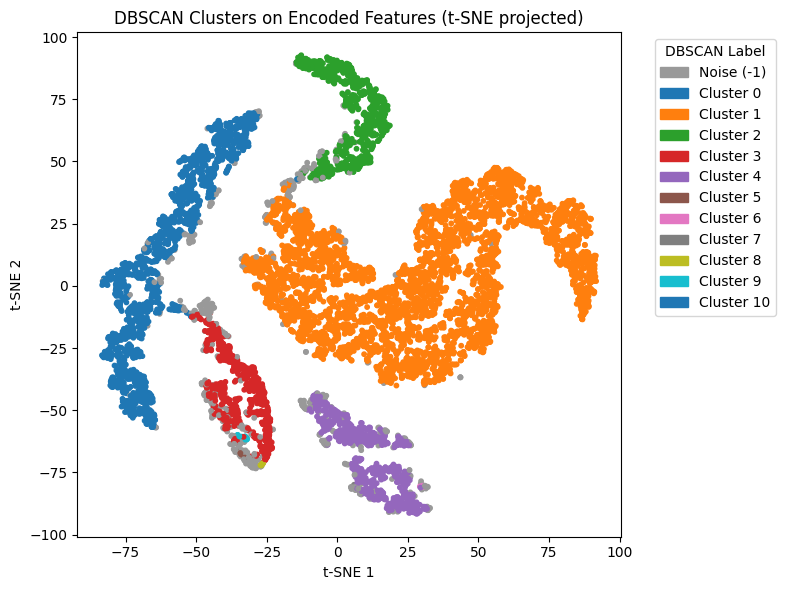

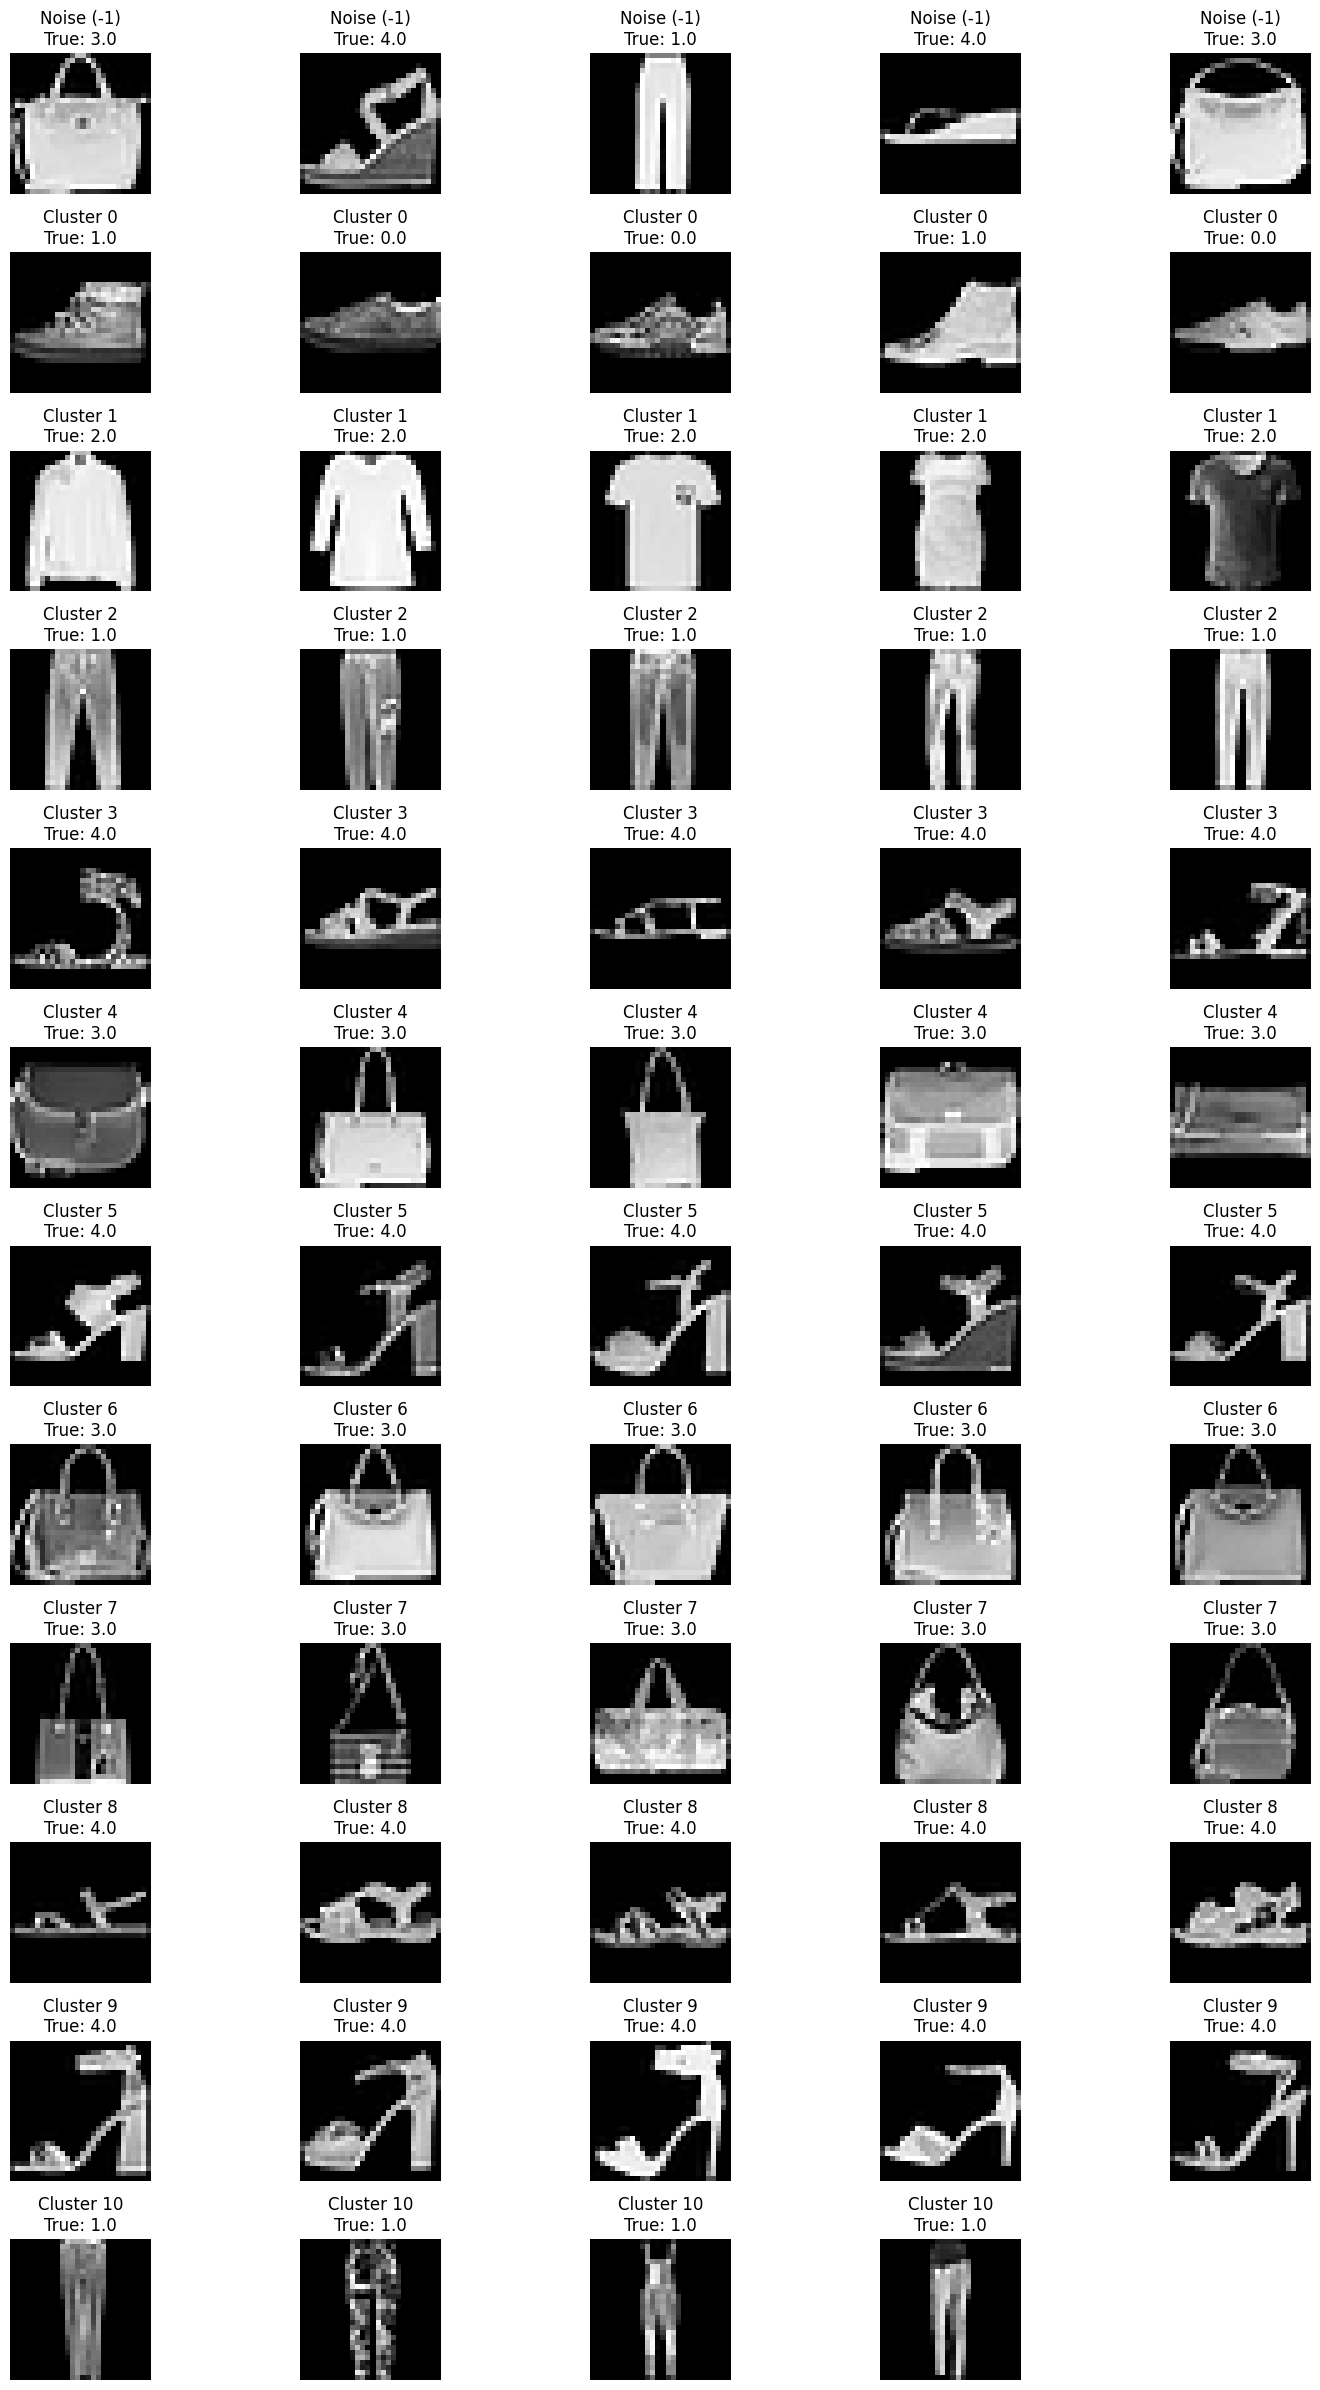

In [ ]:

# DBSCAN 聚类
dbscan = DBSCAN(eps=2.2, min_samples=6)
dbscan_labels = dbscan.fit_predict(X_encoded)

unique_labels = np.unique(dbscan_labels)
print("DBSCAN cluster labels:", unique_labels)

# 自定义颜色：tab10 + 噪声灰色
base_colors = plt.cm.tab10.colors
cmap_colors = []

for lbl in unique_labels:
    if lbl == -1:
        cmap_colors.append((0.6, 0.6, 0.6))  # 灰色噪声
    else:
        cmap_colors.append(base_colors[lbl % len(base_colors)])

cmap = ListedColormap(cmap_colors)

# 绘制散点图
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap=cmap, s=10)
plt.title("DBSCAN Clusters on Encoded Features (t-SNE projected)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# 手动构造 legend
handles = []
for idx, lbl in enumerate(unique_labels):
    if lbl == -1:
        handles.append(mpatches.Patch(color=cmap_colors[idx], label='Noise (-1)'))
    else:
        handles.append(mpatches.Patch(color=cmap_colors[idx], label=f'Cluster {lbl}'))

plt.legend(handles=handles, title="DBSCAN Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# 每个 cluster 展示几张图
n_per_cluster = 5

# 获取唯一的 DBSCAN cluster 标签（包括 -1）
unique_clusters = np.unique(dbscan_labels)

plt.figure(figsize=(15, len(unique_clusters)*2))

img_idx = 1
for cluster_id in unique_clusters:
    cluster_indices = np.where(dbscan_labels == cluster_id)[0]
    n_select = min(n_per_cluster, len(cluster_indices))

    # 随机选择图像
    selected_indices = random.sample(list(cluster_indices), n_select)

    for idx in selected_indices:
        plt.subplot(len(unique_clusters), n_per_cluster, img_idx)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        if cluster_id == -1:
            plt.title(f'Noise (-1)\nTrue: {y_test[idx]}')
        else:
            plt.title(f'Cluster {cluster_id}\nTrue: {y_test[idx]}')
        plt.axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()
